# Fourier-space filtering

In this notebook we cover Fourier-space filtering of ``profiley`` profiles. This functionality requires the ``pixell`` library (<https://github.com/simonsobs/pixell>). The code used to apply the Fourier-space filter included in ``profiley`` was written by Mathew Madhavacheril.

In [10]:
%matplotlib inline
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

from profiley.filtering import Filter
from profiley.nfw import NFW

Let us first load, as usual, our NFW profile.

In [11]:
nfw = NFW(2e14, 4, 0.5, overdensity=500, background='c',
          frame='physical')
print(nfw)

NFW profile object containing 1 profiles. shape: (1,)
  overdensity: 500c
  log mass = 14.30
  concentration = 4.00
  redshift = 0.50


Let's use the lensing convergence observed in the CMB as our observable (where the need for a Fourier-space filter is most likely to arise). CMB maps are usually stacked with fixed angular sizes, not physical, so let's work with angular distances.

We need our profile to be sampled finely enough to apply the filtering. We will then choose the radial bins over which we want to calculate the filtered profile.

Text(0, 0.5, 'convergence $\\kappa$')

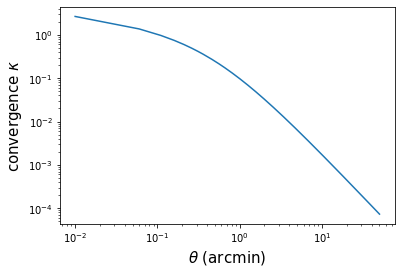

In [27]:
arcmin = np.linspace(0.01, 50, 1000)
rad = np.pi / (60*180) * arcmin
R = nfw.cosmo.kpc_proper_per_arcmin(nfw.z) * arcmin*u.arcmin
kappa = nfw.convergence(R, zs=1100)
plt.loglog(arcmin, kappa)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
plt.ylabel(r'convergence $\kappa$', fontsize=15)

We also require - well - a Fourier-space filter. This filter must be provided in the form of a ``FITS`` file as supported by ``pixell``; we provide as an example here the Fourier-space filter used in Madhavacheril et al. (2020).

In [14]:
filt = Filter('data/kmask_advact_madcows.fits')

As mentioned above, we need to define the radial bins where we are performing our measurements. Note that ``filt.filter`` expects the bin *edges*:

In [19]:
theta_edges = np.linspace(0, 10, 21)
theta = (theta_edges[1:]+theta_edges[:-1]) / 2
theta

array([0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25,
       5.75, 6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75])

Note that, because of the shape convention in ``profiley``, we must pass only the first dimension of ``kappa``. If our ``Profile`` object contains many profiles (i.e., dimensions), then we need to loop over it to pass one profile at a time.

In [22]:
%%time
theta_filtered, kappa_filtered = filt.filter(arcmin, kappa[:,0], theta_edges, units='arcmin')

``theta_filtered`` contains the mid points of the bin edges we gave it:

In [23]:
np.allclose(theta, theta_filtered)

True

Let's see how this looks like then.

(-0.01, 0.2)

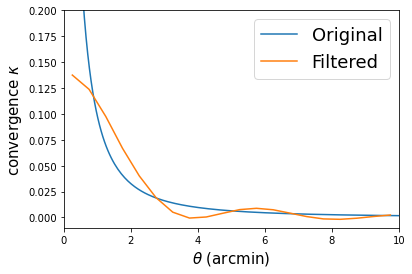

In [35]:
plt.plot(arcmin, kappa, label='Original')
plt.plot(theta, kappa_filtered, label='Filtered')
plt.legend(fontsize=18)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
plt.ylabel(r'convergence $\kappa$', fontsize=15)
plt.xlim(0, 10)
plt.ylim(-0.01, 0.2)